In [78]:
import re
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import srim

In [94]:
# Define calculations in code
ion = srim.Ion('Si', energy=21.0e8) #eV

layer = srim.Layer({
    'Si': {
        'stoich': 0.5,
        'E_d': 35.0, # Displacement Energy
        'lattice': 0.0,
        'surface': 3.0
    },
    'C': {
        'stoich': 0.5,
        'E_d': 20.0, # Displacement Energy
        'lattice': 0.0,
        'surface': 3.0
    }
}, density=3.21, width=1.0e8)
target = srim.Target([layer])

SRIM_EXECUTABLE_DIRECTORY = os.path.abspath('/tmp/srim')
DATA_DIRECTORY = os.path.abspath('/tmp/SiC')
NUM_IONS = 10
TRIM_SETTINGS = {
    'calculation': 2, # full cascade
    'collisions': 2,
    # 'angle_ions': 30
}

trim = srim.TRIM(target, ion, number_ions=NUM_IONS, **TRIM_SETTINGS)

In [95]:
trim.run(SRIM_EXECUTABLE_DIRECTORY)
os.makedirs(DATA_DIRECTORY, exist_ok=True)
srim.TRIM.copy_output_files(SRIM_EXECUTABLE_DIRECTORY, DATA_DIRECTORY)

In [96]:
int_regex = r'\d+'
float_regex = r'-?\d+\.\d*(?:E[+-]\d+)?'
element_regex = r'[A-Z][a-z]?'

ion_regex = 'Ion\s+Energy\s+Depth'
recoil_regex = r'Û\s+(' + r')\s+('.join([int_regex, int_regex, float_regex, float_regex, float_regex, float_regex, int_regex, int_regex]) + r')\s+Û'
cascade_regex = r'³\s*(' + r')\s*³\s*('.join([int_regex, float_regex, float_regex, float_regex, float_regex, float_regex, element_regex, float_regex]) + r')\s*³'

def format_recoil(index, recoil, atom, energy, x, y, z, vacancy, replacement):
    return int(index), int(recoil), int(atom), float(energy), float(x), float(y), float(z), int(vacancy), int(replacement)

def parse_ion_recoil(ion_block):
    return [format_recoil(m.start(), *m.groups()) for m in re.finditer(recoil_regex, ion_block)]

def format_cascade(index, ion, energy, x, y, z, stopping_energy, atom_hit, recoil_energy):
    return int(index), int(ion), float(energy), float(x), float(y), float(z), float(stopping_energy), atom_hit, float(recoil_energy)

def parse_ion_cascade(ion_block):
    return [format_cascade(m.start(), *m.groups()) for m in re.finditer(cascade_regex, ion_block)]

with open('/tmp/SiC/COLLISON.txt', encoding='latin1') as f:
    collision = f.read()

# Tabular Representations

In [97]:
indicies = [(i, m.start()) for i, m in enumerate(re.finditer(ion_regex, collision), start=1)]
ion_indicies_df = pd.DataFrame(indicies, columns=['ion_number', 'index']).set_index('ion_number')

recoils = parse_ion_recoil(collision)
recoils_df = pd.DataFrame(recoils, columns=['index', 'recoil', 'atom', 'energy', 'x', 'y', 'z', 'vacancy', 'replacement']).set_index('index')

cascade = parse_ion_cascade(collision)
cascade_df = pd.DataFrame(cascade, columns=['index', 'ion', 'energy', 'x', 'y', 'z', 'stopping_energy', 'atom_hit', 'recoil_energy']).set_index('index')

In [98]:
cascade_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18934 entries, 2069 to 15871503
Data columns (total 8 columns):
ion                18934 non-null int64
energy             18934 non-null float64
x                  18934 non-null float64
y                  18934 non-null float64
z                  18934 non-null float64
stopping_energy    18934 non-null float64
atom_hit           18934 non-null object
recoil_energy      18934 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.3+ MB


In [99]:
cascade_df.sample(10)

,ion,energy,x,y,z,stopping_energy,atom_hit,recoil_energy
index,,,,,,,,
8692734,6,838000.000,20003000.0,3206.0,-125300.0,96.39,Si,50.231
8605053,6,1046000.000,17646000.0,-7535.0,-112500.0,81.51,Si,536.220
10313590,7,674300.000,21564000.0,16860.0,-34530.0,112.97,C,25.508
11193734,7,5.309,25212000.0,43230.0,-58950.0,13.65,C,126.880
13442907,9,571000.000,22598000.0,-47960.0,43380.0,127.21,C,37.782
5432416,4,394300.000,23721000.0,192600.0,-15270.0,164.08,C,34.143
8332507,6,1691000.000,7909000.0,-916.8,-35010.0,56.02,C,24.084
12590730,8,235.600,25196000.0,-20090.0,-47010.0,76.87,Si,770.860
6370845,4,566.600,25271000.0,212200.0,-812.8,116.32,C,30.759


# Parse only Cascades for Demonstration

In [100]:
energies = []
dedx = []

for i in range(1, len(cascade)):
    c1 = cascade[i-1]
    c2 = cascade[i]
    if c1[1] != c2[1]:
        continue
    
    de = c1[2] - c2[2]
    dx = np.linalg.norm(np.array(c1[3:6]) - np.array(c2[3:6]))
    energies.append(c1[2])
    dedx.append(de/dx)

/home/costrouc/.virtualenvs/srim-implementation-PqLUTV1W/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/costrouc/.virtualenvs/srim-implementation-PqLUTV1W/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


Text(0.5,1,'Electronic Energy Loss Curve')

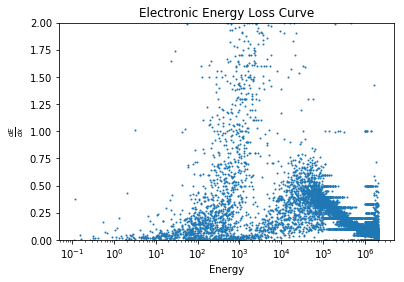

In [105]:
fig, ax = plt.subplots()
ax.scatter(energies, dedx, s=1)
ax.set_ylim([0, 2])
ax.set_xlabel('Energy')
ax.set_ylabel(r'$\frac{dE}{dx}$')
ax.set_xscale('log')
ax.set_title('Electronic Energy Loss Curve')

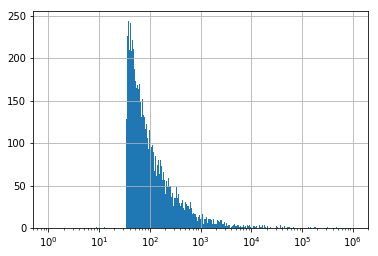

In [106]:
bins = 10**np.linspace(0, 6, 500)
ax = cascade_df[cascade_df['atom_hit'] == 'Si'].recoil_energy.hist(bins=bins)
ax.set_xscale('log')

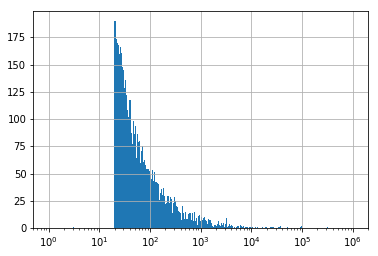

In [107]:
bins = 10**np.linspace(0, 6, 500)
ax = cascade_df[cascade_df['atom_hit'] == 'C'].recoil_energy.hist(bins=bins)
ax.set_xscale('log')

In [108]:
import numpy as np

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [124]:
angles = []
energies = []

for i in range(1, len(cascade)-1):
    c1 = cascade[i-1]
    c2 = cascade[i]
    c3 = cascade[i+1]
    if (c1[1] != c2[1]) or (c2[1] != c3[1]):
        continue
    
    v1 = np.array(c1[3:6]) - np.array(c2[3:6])
    v2 = np.array(c2[3:6]) - np.array(c3[3:6])
    angles.append(angle_between(v1, v2))
    energies.append(c1[2])
    
angles = np.array(angles)

/home/costrouc/.virtualenvs/srim-implementation-PqLUTV1W/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


ValueError: x and y must be the same size

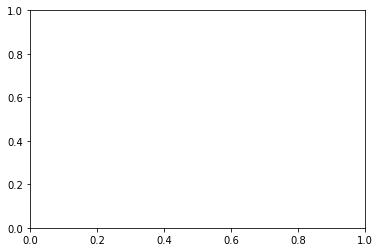

In [123]:
fig, ax = plt.subplots()
ax.scatter(angles, energies, s=1)
ax.set_xlabel('Angle')
ax.set_ylabel(r'Energy')
ax.set_yscale('log')
ax.set_title('Electronic Energy Loss Curve')

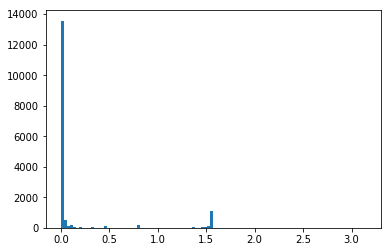

In [130]:
fig, ax = plt.subplots()
ax.hist(angles[~np.isnan(angles)], bins=100)
ax